In [38]:
import warnings
from IPython.display import display as dp
import pandas as pd
import seaborn as sns
import numpy as np
from helpers import *
from modeling_pipelines import *

import joblib
from collections import Counter

# sklearn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
)

# tune
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

# display
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("darkgrid")

🎯 Modeling Goals: 

As the classes are imbalanced, we would use `PR_AUC (average_precision)` as our \
classification metric. 

1. Loan acceptance prediction 
- ensure that we lend to people that can pay us back while keeping a balance.

> `lower FP` is more important than FN

2. Loan grade prediction
> We'd rather predicting people to lower class than to higher class

3. Loan subgrade prediction (with predicted loan grade)


📊 Train test split

- train
- val
- test

In [5]:
acc_df = joblib.load("data/loan_acc_pred_df")
grade_df = joblib.load("data/grade_pred_df")

# loan acceptance prediction
y_acc = acc_df.accepted.values
X_acc = acc_df.drop(columns=["accepted"])

X_acc_train, X_acc_val, y_acc_train, y_acc_val = train_test_split(
    X_acc,
    y_acc,
    test_size=0.01,
    stratify=y_acc,
    random_state=0,
)

# grade prediction
y_grade = grade_df.grade.values
X_grade = grade_df.drop(columns=["grade", "sub_grade", "int_rate"])

X_grade_train, X_grade_val, y_grade_train, y_grade_val = train_test_split(
    X_grade,
    y_grade,
    test_size=0.05,
    stratify=y_grade,
    random_state=0,
)

# sub_grade prediction
# combine grade and subgrade
combo = (
    grade_df.grade.astype("int").astype("string") + grade_df.sub_grade.astype("string")
).astype("int")

subgrade_mapping = {
    v: k
    for k, v in dict(
        enumerate(sorted(list(Counter(combo.astype("int")).keys())))
    ).items()
}

mapped_subgrade = combo.apply(lambda i: subgrade_mapping[i])
grade_df["sub_grade"] = mapped_subgrade

y_sub_grade = grade_df.sub_grade.values
X_sub_grade = grade_df.drop(columns=["sub_grade", "int_rate"])


X_sub_grade_train, X_sub_grade_val, y_sub_grade_train, y_sub_grade_val = (
    train_test_split(
        X_sub_grade,
        y_sub_grade,
        test_size=0.05,
        stratify=y_sub_grade,
        random_state=0,
    )
)

📊 Stratify cv splits for nested cv

In [6]:
tuning_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
model_selection_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

---

📊 Loan acceptance prediction

Use Optuna to test out 4 models:

1. `xgb_smote`: xgboost (imbalanced) with SMOTE.

2. `xgb_balance`: xgboost with internal class balancing

3. `xgb_balance_imp_free`: xgboost has internal function to deal with \
imputation, test if this performs better than user defined imputation strategy.

4. `balanced_rf`: BalancedRandomForestClassifier from imblearn.


🔴 Note, as Optuna is slow to run (>30 mins), for most models below, I load \
serialized model that's aready optimized so reviewers don't have to train the \
model. 

1. acc_xgb_smote

In [8]:
# DEMO Optuna code: uncomment to run (takes approx. 30 minutes)

# acc_xgb_smote_study = optuna.create_study(
#     direction="maximize", storage=storage, study_name="acc_xgb_smote_pipeline"
# )

# acc_xgb_smote_study.optimize(
#     lambda trial: objective(
#         trial, X_acc_train, y_acc_train, acc_xgb_smote_pipeline, cv=tuning_cv
#     ),
#     n_trials=25,
#     n_jobs=-1,
# )

best_acc_xgb_smote = joblib.load("data/acc_xgb_smote")

model = best_acc_xgb_smote

bprint("best_acc_xgb_smote")
dp(model)

cv_score_summary(model, X_acc_val, y_acc_val, cv=model_selection_cv)


best_acc_xgb_smote


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_requested', 'risk_score', 'debt_to_income_ratio',
       'employment_length', 'loan_title_other', 'amnt_req_big'],
      dtype='object')),
                                                 ('categor...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

cv: [0.94145338 0.94751155 0.91990782 0.94736587 0.92779828]
cv_mean: 0.9368
cv_std: 0.011085


2. acc_xgb_balanced

In [9]:
best_acc_xgb_balanced = joblib.load("data/acc_xgb_balanced")
model = best_acc_xgb_balanced

bprint("best_acc_xgb_balanced")
dp(model)

cv_score_summary(model, X_acc_val, y_acc_val, cv=model_selection_cv)


best_acc_xgb_balanced


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['amount_requested', 'risk_score', 'debt_to_income_ratio',
       'employment_length', 'loan_title_other', 'amnt_req_big'],
      dtype='object')),
                                                 ('categorcal_pipeline',
                                                  Targe...
                               feature_types=None, gamma=0.38614602252609365,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=82, n_jobs=None,
                               num_parallel_tree=None, ...))])

cv: [0.88806131 0.89611672 0.8867617  0.89645013 0.88855204]
cv_mean: 0.8912
cv_std: 0.004202


3. acc_xgb_balanced_imp_free

In [12]:
best_acc_xgb_balanced_imp_free = joblib.load("data/acc_xgb_balanced_imp_free")
model = best_acc_xgb_balanced_imp_free

bprint("best_acc_xgb_balanced_imp_free")
dp(model)

cv_score_summary(model, X_acc_val, y_acc_val, cv=model_selection_cv)


best_acc_xgb_balanced_imp_free


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['amount_requested', 'risk_score', 'debt_to_income_ratio',
       'employment_length', 'loan_title_other', 'amnt_req_big'],
      dtype='object')),
                                                 ('categorcal_pipeline',
                                                  TargetEncoder(),
                                                  Index(['loan_titl...
                               feature_types=None, gamma=0.4129681081583219,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=176, n_jobs=None,
                               num_parallel_tree=None, ...))])

cv: [0.93771331 0.94183943 0.94355724 0.94066782 0.93826521]
cv_mean: 0.9404
cv_std: 0.002186


4. balanced_rf

In [13]:
best_acc_balanced_rf = joblib.load("data/acc_balanced_rf")
model = best_acc_balanced_rf

bprint("best_acc_balanced_rf")
dp(model)

cv_score_summary(model, X_acc_val, y_acc_val, cv=model_selection_cv)


best_acc_balanced_rf


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_requested', 'risk_score', 'debt_to_income_ratio',
       'employment_length', 'loan_title_other', 'amnt_req_big'],
      dtype='object')),
                                                 ('categorcal_pipeline',
                                                  TargetEncoder(),
                                                  Index(['loan_title', 'state'], dtype='object'))])),
                ('model',
                 BalancedRandomForestClassifier(bootstrap=True,
                                                criterion='entropy',
                                                max_depth=7, n_estimators=69,
                                                n_jobs=-1, random_state=0,
                                                replacement=True,
                                                sampling_strategy='all'))])

cv: [0.87219309 0.87943745 0.88017118 0.87946626 0.87302812]
cv_mean: 0.8769
cv_std: 0.003489


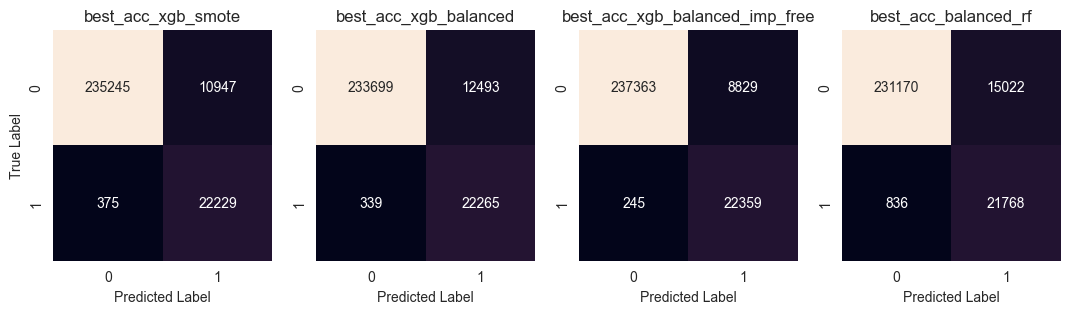

In [14]:
fig_size(13, 3)
plt.subplot(1, 4, 1)
cv_pred = cross_val_predict(
    best_acc_xgb_smote,
    X_acc_val,
    y_acc_val,
    cv=model_selection_cv,
)
plot_confusion(cv_pred, y_acc_val, "best_acc_xgb_smote")

plt.subplot(1, 4, 2)
cv_pred = cross_val_predict(
    best_acc_xgb_balanced,
    X_acc_val,
    y_acc_val,
    cv=model_selection_cv,
)
plot_confusion(cv_pred, y_acc_val, "best_acc_xgb_balanced")
plt.ylabel("")

plt.subplot(1, 4, 3)
cv_pred = cross_val_predict(
    best_acc_xgb_balanced_imp_free,
    X_acc_val,
    y_acc_val,
    cv=model_selection_cv,
)
plot_confusion(cv_pred, y_acc_val, "best_acc_xgb_balanced_imp_free")
plt.ylabel("")


plt.subplot(1, 4, 4)
cv_pred = cross_val_predict(
    best_acc_balanced_rf,
    X_acc_val,
    y_acc_val,
    cv=model_selection_cv,
)
plot_confusion(cv_pred, y_acc_val, "best_acc_balanced_rf")
plt.ylabel("")

plt.show()

📝 Compare 4 loan acceptance prediction models

The undoubtedly best performing model is the: \
`xgb + class_balance strategy + built-int imputation`. \
It has the lowest false negative rate and lowest false positive rate. 


📊 Should we tune the threshold ? 

In [ ]:
best_acc_xgb_balanced_imp_free.fit(X_acc_val, y_acc_val)
pred_prob_neg = best_acc_xgb_balanced_imp_free.predict_proba(X_acc_val).T[0]
pred_prob_pos = best_acc_xgb_balanced_imp_free.predict_proba(X_acc_val).T[1]

precision_neg, recall_neg, threshold_neg = precision_recall_curve(
    y_acc_val, pred_prob_neg
)

precision_pos, recall_pos, threshold_pos = precision_recall_curve(
    y_acc_val, pred_prob_pos
)

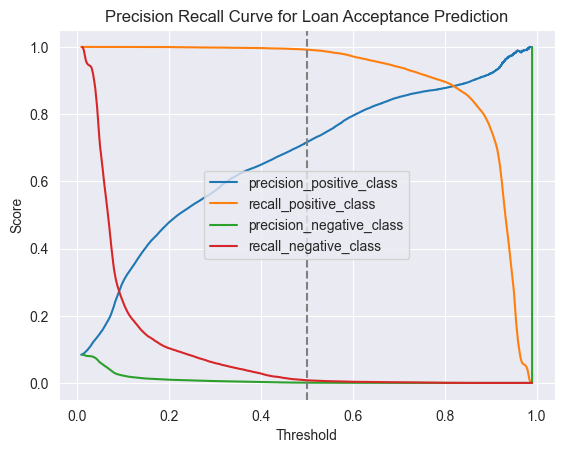

In [69]:
sns.lineplot(
    x=threshold_pos, y=list(precision_pos[1:]), label="precision_positive_class"
)
sns.lineplot(x=threshold_pos, y=list(recall_pos[:-1]), label="recall_positive_class")

sns.lineplot(
    x=threshold_neg, y=list(precision_neg[1:]), label="precision_negative_class"
)
sns.lineplot(x=threshold_neg, y=list(recall_neg[:-1]), label="recall_negative_class")

plt.title("Precision Recall Curve for Loan Acceptance Prediction")
plt.ylabel("Score")
plt.xlabel("Threshold")

plt.axvline(0.5, linestyle="--", color="gray")
plt.show()

📝 PR-AUC curve for loan acceptance prediction

The defeult 0.5 threshold is fair for our goal. \
If we tune up the threshold, we would make the precision and recall of negative \
class worse, as we care about identifying the loan_rejected applicants, this is \
not desirable.

If we tune down the threshold, we would need to sacrafice 2 times the precision \
of the positive class to have one time increase in the recall of the negative \
class. 

> Leave the threshold at 0.5, don't tune it. 

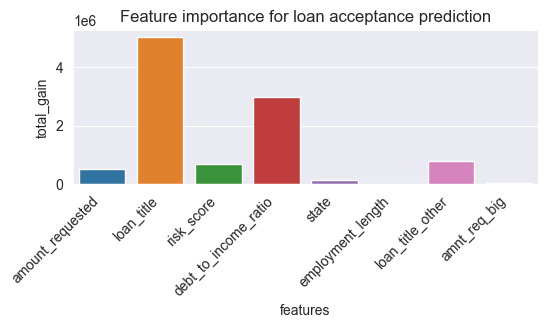

In [145]:
acc_pred_feats = X_acc_train.columns.tolist()
acc_pred_fi = list(
    best_acc_xgb_balanced_imp_free[-1]
    .get_booster()
    .get_score(importance_type="total_gain")
    .values()
)

acc_pred_fi_df = {acc_pred_feats[i]: acc_pred_fi[i] for i in range(len(acc_pred_feats))}

acc_pred_fi_df = pd.DataFrame([acc_pred_fi_df])
fig_size(6, 2)
sns.barplot(data=acc_pred_fi_df)
plt.xticks(rotation=45, ha="right")
plt.title("Feature importance for loan acceptance prediction")
plt.xlabel("features")
plt.ylabel("total_gain")

plt.show()

📝 Feature importance for loan acceptance prediction

`Loan_title` leads to the highest total_gain in the xgboost model, followed by \
`dti`. Even the loan_title deriving feature: loan_title_other has very high gain.

From eda we know that risk_score, dti, and employment_length are three features \
that encodes the applicant's credit history and quality, so these 3 feature \
have higher correlation with one another. If we put all and their deriving features \
together, the importance would be similar to loan_title. 


dump the winning model in the deployment repo

In [40]:
joblib.dump(best_acc_xgb_balanced_imp_free, 'lending_club_deployment/loan_acc_prediction_winner.pkl')

----

📊 Loan grade prediction

Loan grade prediction is a multiclass classification (7 classes). \
Here we'd try 2 models:

1. xgb_smote
2. balanced_rf

1. xgb_smote


In [70]:
grade_xgb_smote = joblib.load("data/grade_xgb_smote")
model = grade_xgb_smote

bprint("grade_xgb_smote")
dp(model)

cv_score_summary(model, X_grade_val, y_grade_val, cv=model_selection_cv)


grade_xgb_smote


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['loan_amnt', 'term',
                                                   'installment', 'annual_inc',
                                                   'verification_status', 'dti',
                                                   'earliest_cr_line',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'revol_bal', 'rev...
                               feature_types=None, gamma=0.31483132294302313,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=273, n_jobs=-1,
                               num_parallel_tree=None, ...))])

cv: [0.35527316 0.3634642  0.36714458 0.35575166 0.36381484]
cv_mean: 0.3611
cv_std: 0.004734


2. balanced_rf

In [76]:
grade_balanced_rf = joblib.load("data/grade_balanced_rf_fitted")
model = grade_balanced_rf

bprint("grade_balanced_rf")
dp(model)

cv_score_summary(model, X_grade_val, y_grade_val, cv=model_selection_cv)


grade_balanced_rf


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['loan_amnt', 'term',
                                                   'installment', 'annual_inc',
                                                   'verification_status', 'dti',
                                                   'earliest_cr_line',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last...
                                                   'tot_cur_bal', 'open_acc_6m',
                                                   'open_il_12m', 'open_il_24m',
                                                   'mths_since_rcnt_il',
                                                   'il_util', ...]),
                                                 ('categorcal_pipeline',
                                                  TargetEncoder(),
                                                  ['purpose',
                                                   'initial_list_status'])])),
                ('model',
                 BalancedRandomForestClassifier(bootstrap=True,
                                                class_weight='balanced',
                                                criterion='entropy',
                                                max_depth=241, n_estimators=498,
                                                n_jobs=-1, random_state=0,
                                                replacement=True,
                                                sampling_strategy='all'))])

cv: [0.34620736 0.35249416 0.35988514 0.35390906 0.35386927]
cv_mean: 0.3533
cv_std: 0.004359


📊 Compare two models with validation data:

In [78]:
grade_xgb_smote_fitted = grade_xgb_smote.fit(X_grade_train, y_grade_train)
grade_xgb_smote_pred = grade_xgb_smote_fitted.predict(X_grade_val)

grade_balanced_rf_fitted = grade_balanced_rf.fit(X_grade_train, y_grade_train)
grade_balanced_rf_pred = grade_balanced_rf_fitted.predict(X_grade_val)

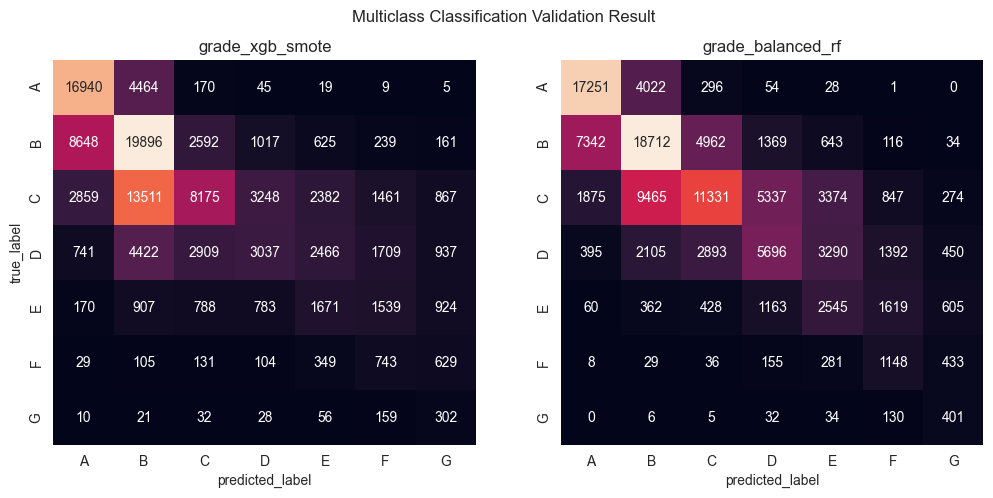

In [148]:
fig_size(12, 5)
plt.suptitle("Multiclass Classification Validation Result")
plt.subplot(1, 2, 1)
sns.heatmap(
    confusion_matrix(y_grade_val, grade_xgb_smote_pred),
    annot=True,
    fmt=".0f",
    cbar=False,
)
plt.xlabel("predicted_label")
plt.ylabel("true_label")
plt.xticks(np.arange(0.5, 7.5, 1), ["A", "B", "C", "D", "E", "F", "G"])
plt.yticks(np.arange(0.5, 7.5, 1), ["A", "B", "C", "D", "E", "F", "G"])

plt.title("grade_xgb_smote")
plt.subplot(1, 2, 2)
sns.heatmap(
    confusion_matrix(y_grade_val, grade_balanced_rf_pred),
    annot=True,
    fmt=".0f",
    cbar=False,
)
plt.xlabel("predicted_label")
plt.title("grade_balanced_rf")
plt.xticks(np.arange(0.5, 7.5, 1), ["A", "B", "C", "D", "E", "F", "G"])
plt.yticks(np.arange(0.5, 7.5, 1), ["A", "B", "C", "D", "E", "F", "G"])

plt.show()

📝 Compare multiclass prediction of two models 

Looking solely at the PR_AUC value, it looks like xgb_smote is performing slightly \
better than balanced_random_forest.

But looking at the confusion metric of individual classes, there's more details.

1. The balanced_rf model has classified the labels more adjacent to its true class, \
we can observe the brighter color on the diagonal (📏) of the confusion metrics \
in contrast to xgb_smote model. 

2. The model is also more safe/ pessimistic in the prediction, it tends to \
predict lower class (3 -> 4) to higher class comparing to the other model, \
this is more aligned to our goal of playing safe.

3. Moreover, the balanced_rf model takes much less time to train.

> Thus, for the subclass prediction, we would also use the balanced_rf.

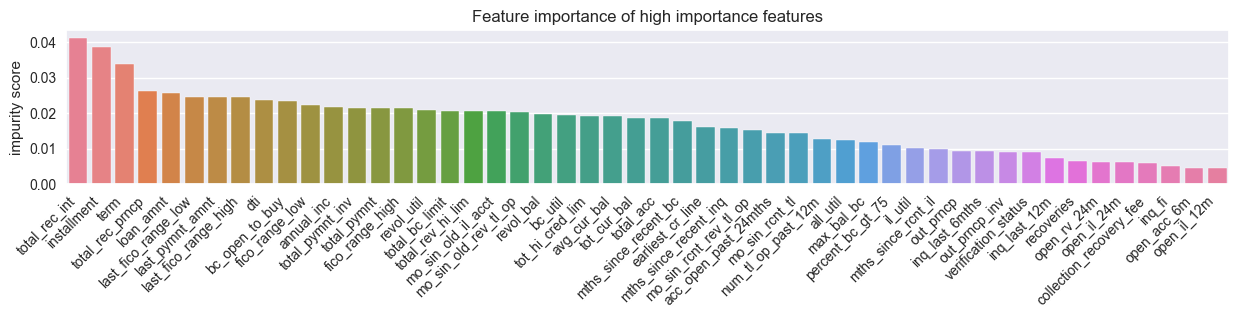

In [280]:
num_feats = sub_grade_num_cols
feat_imp = list(grade_balanced_rf_fitted[-1].feature_importances_)[:50]

feat_imp_df = (
    pd.DataFrame({num_feats[i]: [feat_imp[i]] for i in range(50)}, index=["imp"])
    .T.sort_values(by="imp", ascending=False)
    .T
)

fig_size(15, 2)
sns.barplot(data=feat_imp_df)
plt.xticks(rotation=45, ha="right")
plt.title("Feature importance of high importance features")
plt.ylabel("impurity score")
plt.show()

There's no feature with exceptionally high feature importance.

The most important features are:
1. `total_rec_int`: interest_received_to_data
2. `installment`: The monthly payment owed by the borrower if the loan originates.
3. `term`: The number of payments on the loan. Values are in months and can be either 36 or 60.

---

📊 Loan subgrade prediction

BalancedRandomForest performs well in imbalanced multiclass prediction, thus \
we would continue to use it for subgrade prediction

In [14]:
sub_grade_balanced_rf = joblib.load("data/sub_grade_balanced_rf")
model = sub_grade_balanced_rf

bprint("sub_grade_balanced_rf")
dp(model)

cv_score_summary(model, X_sub_grade_val, y_sub_grade_val, cv=model_selection_cv)


sub_grade_balanced_rf


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['loan_amnt', 'term',
                                                   'installment', 'annual_inc',
                                                   'verification_status', 'dti',
                                                   'earliest_cr_line',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths'...
                                                   'last_fico_range_low',
                                                   'tot_cur_bal', 'open_acc_6m',
                                                   'open_il_12m', 'open_il_24m',
                                                   'mths_since_rcnt_il',
                                                   'il_util', ...]),
                                                 ('categorcal_pipeline',
                                                  TargetEncoder(),
                                                  ['purpose',
                                                   'initial_list_status'])])),
                ('model',
                 BalancedRandomForestClassifier(bootstrap=True,
                                                class_weight='balanced',
                                                max_depth=340, n_estimators=98,
                                                n_jobs=-1, random_state=0,
                                                replacement=True,
                                                sampling_strategy='all'))])

cv: [0.08826452 0.10102551 0.08616557 0.10676418 0.10218729]
cv_mean: 0.0969
cv_std: 0.00815


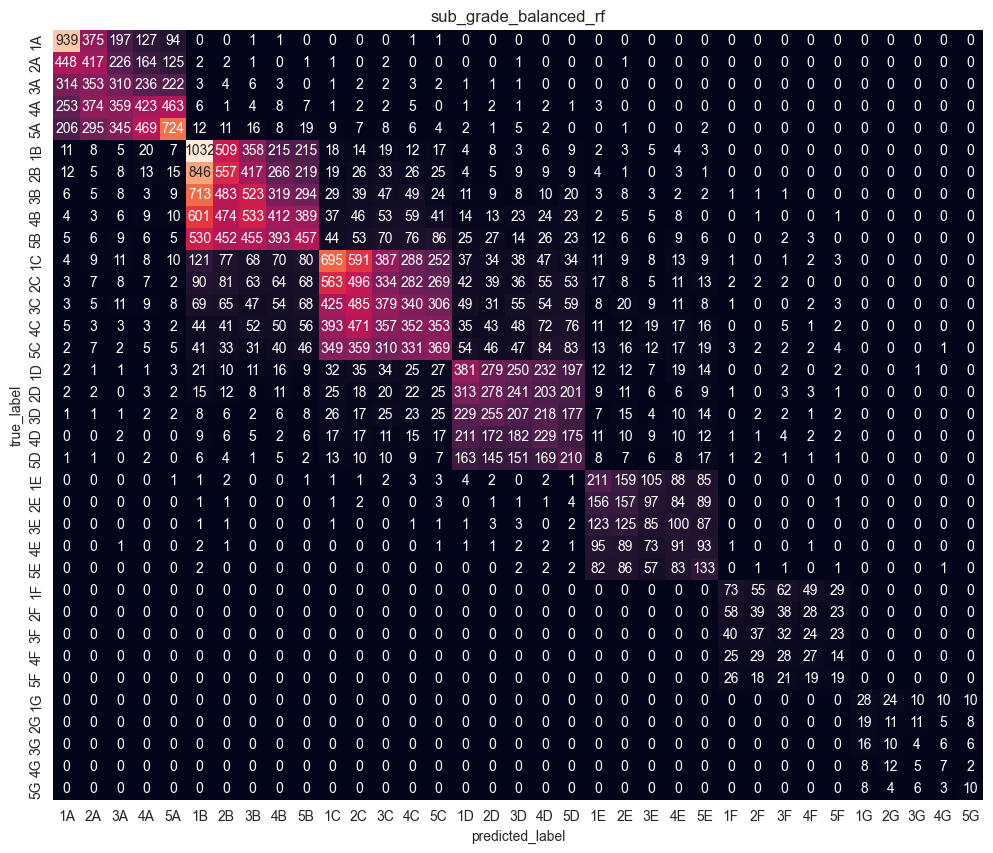

In [115]:
sub_grade_balanced_rf_fitted = sub_grade_balanced_rf.fit(
    X_sub_grade_train, y_sub_grade_train
)

sub_grade_balanced_rf_pred = sub_grade_balanced_rf_fitted.predict(
    X_sub_grade_val)

fig_size(12, 10)
sns.heatmap(
    confusion_matrix(y_sub_grade_val, sub_grade_balanced_rf_pred),
    annot=True,
    fmt=".0f",
    cbar=False,
)

num_ls = ["1", "2", "3", "4", "5"]
alph_ls = ["A", "B", "C", "D", "E", "F", "G"]
subgrade_ls = [i + j for j in alph_ls for i in num_ls]

plt.xticks(np.arange(0.5, 35.5, 1), subgrade_ls)
plt.yticks(np.arange(0.5, 35.5, 1), subgrade_ls)

plt.xlabel("predicted_label")
plt.ylabel("true_label")
plt.title("sub_grade_balanced_rf")

plt.show()

📝 Subgrade Prediction with Balanced RandomForest

With grade provided as a feature, it seems like the model is relying heavily on \
it, we can see the 5*5 grade square every 5 labels. 

Looking at each subgrade individually, majority of them have the highest \
prediction on the correct subgrade, otherwise on the neighboring subgrade. 

📝 Feature importance

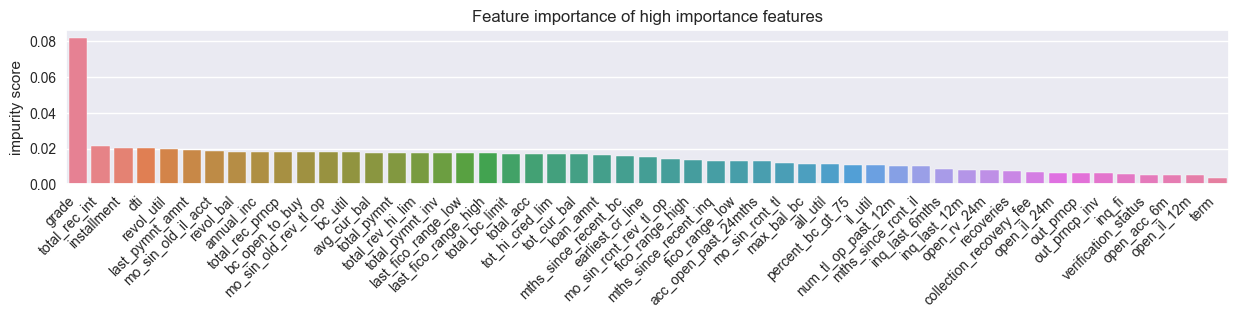

In [276]:
num_feats = sub_grade_num_cols
feat_imp = list(sub_grade_balanced_rf[-1].feature_importances_)[:51]

feat_imp_df = (
    pd.DataFrame({num_feats[i]: [feat_imp[i]]
                 for i in range(51)}, index=["imp"])
    .T.sort_values(by="imp", ascending=False)
    .T
)

fig_size(15, 2)
sns.barplot(data=feat_imp_df)
plt.xticks(rotation=45, ha="right")
plt.title("Feature importance of high importance features")
plt.ylabel("impurity score")
plt.show()

📝 Subgrade Prediction feature importance

In the feature importance plot, grade is the most important feature, \
this corresponds with the finding in the confusion matrix.

The other top important features are similar to those of grade prediction.

💡 Some improvements for the project

1. Implement null, duplication, amomalies handling also in the pipeline.
2. Dive deeper into the EDA of grade prediction related features.
3. Look into individual misclassificed cases for error analysis.
4. Better memory management (down cast data type, get more RAM, train on cloud) \
to save training time.
